#获得指定关键字的tweet数据集
------用Ajax请求Twitter服务器以json格式连续返回定制data

##1.问题VS途径
- 国内的屏蔽 (shadowsocks)
- 数据封闭 (twitterAPI-twitterSearch)
- 动态加载 (模拟Ajax-模拟Brower) 
- 随机参数 (自动下拉-截获参数)
- 服务器限制 (设定延迟)
- 时间规模 (设置代理之SSL认证-群集)

##2.起因
有一天, 有人问我可不可以提供 twitter 在2014年一年的 tweets 数据，要拿来做数据分析。  

闲来无事，大略查看一下，推特 2012 年号称注册用户 5 亿，活跃用户 1 亿，假设每人每天 1 条推文，就是 1 x 365 x 100000000 = 356 亿条记录。

这基本是不可能完成的任务。

但是有人又问，可不可以获得 twitter 2014 年 100 个关键词的数据。

这是可以尝试的。

##3.过程

###国内的屏蔽 (shadowsocks)

首先是访问限制，这里我们用 shadowsocks 来获得途径，按下不表。

###数据封闭 (twitterAPI-twitterSearch)
其次是 Twitter 对自身数据的高度重视，以至于各种无偿获取 tweets 的途径都被废止了。具体表现在：
- 各种基于推特数据服务的企业，或被推特收购，或被告知停止服务，或收取昂贵的会员费。如 Gnip, Datasift, Scraperwiki 等，其中Scraperwiki  之前提供自由的推特数据服务，但是被推特勒令停止，现在变成收取每月 $2000 美元的会员费。学术界获取数据进行数据挖掘也变得越来越难，具体可以参考这篇国外[博文](http://blogs.lse.ac.uk/usappblog/2015/01/03/a-political-economy-of-twitter-data-conducting-research-with-proprietary-data-is-neither-easy-nor-free/)。
- Twitter 自身的开发者账号提供的 API 可以每 15 分钟 180 次查询，每次查询返回 100 条记录。然而中国的电话号码却不能注册开发者账号，一直显示号码无效。即便从国外找来了一个开发者账号，获得了推特的 consumer_key 和 consumer_secret，经过试验，依然无效。
- Apple 为了研究消费趋势，花费了 2 亿美元购买 Twitter 的数据服务，具体报道可以搜索。
- Twitter 明白了，数据就是宝，不能随便拿。

好在我们发现 Twitter 还保留了一个面向用户的搜索页面，可以返回所有推特数据。https://twitter.com/search-home

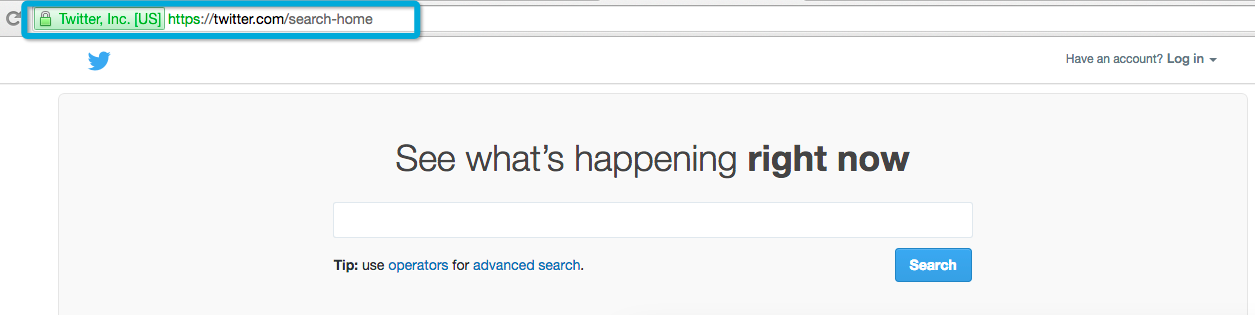

In [4]:
from IPython.display import Image
Image(filename='t.png')

这正是我们所需要的。

###动态加载 (模拟Ajax-模拟Brower) 

现在我们发现，这个查询页面可以按照各种参数返回数据，但却是动态加载的，必须将页面下拉到底部，才会进一步加载剩余的 tweet 数据。

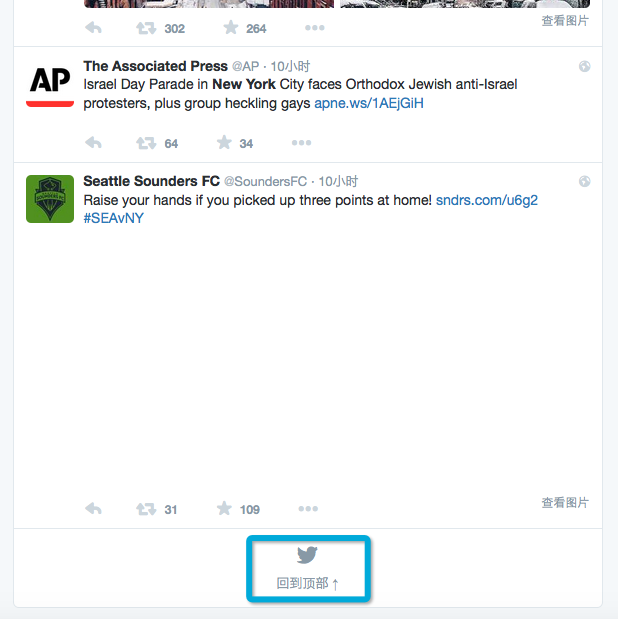

In [7]:
from IPython.display import Image
Image(filename='t1.png')

这样，通过单纯的构造 URL 请求是不行的，因为动态加载数据这部分无法获得。有两个办法：
- 1.构造 Ajax 请求直接获取服务器返回的动态数据。
- 2.用模拟浏览器自动下拉来获取加载数据后的html页面。

###方法一无论如何也无法获得服务器响应，无论是添加 cookie, 添加 User-Agent, 还是添加所有查询参数。代码如下：

In [ ]:
import json
import urllib
import urllib2
from requests import Session
import httplib
from OpenSSL import SSL
import ssl


query =urllib.urlencode(dict(q='Beijing lang:en since:2014-01-01 until:2014-12-31',
                             src='typd',
                             include_entities=1,
                             scroll_cursor='TWEET-549497992349511682-550053671866994688-BD1UO2FFu9QAAAAAAAAETAAAAAcAAAASAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA',
                             vertical='default',
                             include_available_features=1,
                             composed_count=0,
                             f='tweets',
                             include_new_items_bar='true',
                             interval=30000,
                             latent_count=0,
                             ))

headers={
'Accept':'application/json, text/javascript, */*; q=0.01',
'Accept-Encoding':'gzip, deflate',
'Accept-Language':'en-US,en;q=0.5',
'Connection':'keep-alive',
'Host':'twitter.com',
'If-Modified-Since':'Fri, 22 May 2015 03:52:45 GMT',
'Cookie':'external_referer="K0c47Lz/loXd1LFS05uusZNfHjpZwknS9VUNU3wjUYX+yZ03EIU8Pg==|1"; lang=en; guest_id=v1%3A143203162100398741; remember_checked_on=0; external_referer="ZLhHHTiegr9NFZkG/Yp8HowjNCYhJTLnKvqWZETfN3zNHClJsBsftg==|0"; _ga=GA1.2.478472660.1432031647; eu_cn=1; _twitter_sess=BAh7CiIKZmxhc2hJQzonQWN0aW9uQ29udHJvbGxlcjo6Rmxhc2g6OkZsYXNo%250ASGFzaHsABjoKQHVzZWR7ADoPY3JlYXRlZF9hdGwrCPQWLXlNAToHaWQiJThi%250AYzZlNDQzNDZlNTY5Y2YwNTQxNjY5ZmFkZDRjM2M5Ogxjc3JmX2lkIiUyOWRi%250AMDhkOWZiYjNjNzc2ODY4OTg3ZGY0YjY1OThmZToJdXNlcmwrB4lQ8b8%253D--0b13eae333bdfa3dcb4a0955d5d49e26b87159e2; lang=en; eu_cn=1; __utma=43838368.478472660.1432031647.1432264189.1432264189.1; __utmc=43838368; __utmz=43838368.1432264189.1.1.utmcsr=(direct)|utmccn=(direct)|utmcmd=(none); dnt=1',
'Content-Type':'application/json',
'Referer':'https://twitter.com/search?q=%E5%8C%97%E4%BA%AC%20lang%3Aen%20since%3A2014-01-01%20until%3A2014-12-31&src=typd&vertical=default&f=tweets',
'User-Agent':'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.10; rv:38.0) Gecko/20100101 Firefox/38.0',
'X-Requested-With':'XMLHttpRequest',
'X-Twitter-Polling':'true',
}

url = "https://twitter.com/i/search/timeline?" + query
request = urllib2.Request("https://twitter.com/i/search/timeline?" + query,None,headers=headers)
result = urllib2.urlopen(request)
data = json.load(result)

print data


运行结果如下：

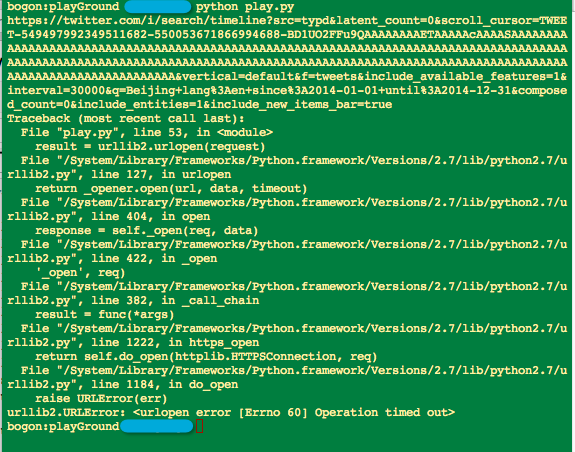

In [8]:
from IPython.display import Image
Image(filename='t2.png')

###方法二可以用 Selenium 模拟浏览器，自动下拉直到所有数据加载完毕。代码如下：

In [ ]:
#coding=utf-8

from selenium import webdriver
import sys
import urllib
import unittest, time, re

canshu= 'Shanghai lang:en since:2014-01-01 until:2015-01-01'#搜索参数
www = 'https://twitter.com/search?'#主页面

#构造请求参数，f表示所有twitters.
query = urllib.urlencode(dict(q=canshu,
                              sec='typd',
                              vertical='default',
                              #f='tweets',
                              ))

#设定内置浏览器禁止加载图片
firefox_profile = webdriver.FirefoxProfile()
firefox_profile.set_preference('permissions.default.image',2)
firefox_profile.set_preference('permissions.default.stylesheet',2)#禁用css


class Sel(unittest.TestCase):
    def setUp(self):
        self.driver = webdriver.Firefox(firefox_profile=firefox_profile)#实例化火狐并添加禁止图片css设定。
#        self.driver = webdriver.Chrome()
        self.driver.implicitly_wait(30)
        self.base_url = www
        self.verificationErrors = []
        self.accept_next_alert = True
    def test_sel(self):
        driver = self.driver
        delay = 3
        driver.get(self.base_url + query)
        #driver.find_element_by_link_text("All").click()
        for i in range(1,1000):
            self.driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
            time.sleep(5)
        html_source = driver.page_source
        data = html_source.encode('utf-8')


if __name__ == "__main__":
    unittest.main()


然而这种方法生成的 html 文件过大，浏览器无法顺利保存，也就无法用工具提取 html  里渲染好的 tweets 数据了。

###那么我们该怎么办呢？

既然模拟 Ajax 不成功，模拟浏览器成功，那么我们就可以用浏览器模拟 Ajax 请求，就是用 Selenium 发送 Ajax 请求获得动态 Json 数据。代码如下：

In [ ]:
#coding=utf-8
import os
from selenium import webdriver
from selenium.webdriver.common.proxy import *
import sys
import unittest, time, re
import json
import urllib
import urllib2

canshu= 'Shanghai lang:en since:2014-01-01 until:2015-01-01'#搜索参数
www = 'https://twitter.com/i/search/timeline?'#主页面
mimi =''

query =urllib.urlencode(dict(q='Beijing lang:en since:2014-01-01 until:2014-12-31',
                             src='typd',
                             include_entities=1,
                             #scroll_cursor = 'TWEET-549520628957458432-550078740466651136-BD1UO2FFu9QAAAAAAAAETAAAAAcAAAASAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA',
                             vertical='default',
                             include_available_features=1,
                             composed_count=0,
                             f='tweets',
                             include_new_items_bar='true',
                             interval=30000,
                             latent_count=0,
                             ))


#设定内置浏览器禁止加载图片
firefox_profile = webdriver.FirefoxProfile()#'/Users/chengang/Desktop/profile/'
firefox_profile.set_preference('permissions.default.image',2)
firefox_profile.set_preference('permissions.default.stylesheet',2)#禁用css
#firefox_profile.set_preference('javascript.enabled',false)#禁用 js

#自动保存文件
firefox_profile.set_preference('browser.download.folderList',2)#2询问下载位置，1下载目录，0桌面
firefox_profile.set_preference('browser.download.manager.showWhenStarting',False)
firefox_profile.set_preference('browser.download.dir', '~/Document')
firefox_profile.set_preference('browser.helperApps.neverAsk.saveToDisk','application/json')
firefox_profile.update_preferences()

driver = webdriver.Firefox(firefox_profile=firefox_profile)#实例化火狐并添加禁止图片css设定。
driver.get(www+ query)
time.sleep(2)

jsonfile = open('/Users/chengang/Document/json.json').read()
driver.implicitly_wait(6)
time.sleep(2)

data = json.loads(jsonfile.decode('utf-8-sig'))
for i in data.items():
    if i[0] == "scroll_cursor":
        global mimi
        mimi = i[1]
        print mimi
driver.quit()
time.sleep(2)

z =1
while 1:

    query2 =urllib.urlencode(dict(q='Beijing lang:en since:2014-01-01 until:2014-12-31',
                                  src='typd',
                                  include_entities=1,
                                  scroll_cursor = mimi,
                                  vertical='default',
                                  include_available_features=1,
                                  composed_count=0,
                                  f='tweets',
                                  include_new_items_bar='true',
                                  interval=30000,
                                  latent_count=0,
                                  ))

    firefox_profile = webdriver.FirefoxProfile()
    firefox_profile.set_preference('permissions.default.image',2)
    firefox_profile.set_preference('permissions.default.stylesheet',2)#禁用css
    #firefox_profile.set_preference('javascript.enabled',false)#禁用 js

    #自动保存文件
    firefox_profile.set_preference('browser.download.folderList',2)#2询问下载位置，1下载目录，0桌面
    firefox_profile.set_preference('browser.download.manager.showWhenStarting',False)
    firefox_profile.set_preference('browser.download.dir', '~/Document')
    firefox_profile.set_preference('browser.helperApps.neverAsk.saveToDisk','application/json')

    driver = webdriver.Firefox(firefox_profile=firefox_profile)#实例化火狐并添加禁止图片css设定。

    driver.set_window_position(1400,100)#设定窗口位置
    driver.set_window_size(3,3)#设定窗口大小
    
    driver.implicitly_wait(300)
    driver.delete_all_cookies()#清空浏览器cookie
    driver.get(www+ query2)
    time.sleep(2)

    jsonfile = open('/Users/chengang/Document/json('+str(z)+').json').read()
    time.sleep(2)
    z = z+1
    driver.implicitly_wait(6)

    data = json.loads(jsonfile.decode('utf-8-sig'))
    for n in data.items():
        if n[0] == "scroll_cursor":
            global mimi
            mimi = n[1]
            print mimi
    driver.close()
    time.sleep(2)


###随机参数 (截获参数)

其中获得的 json 文件包含了 scroll_cursor 参数，这是构造下一个 URL 请求的必备参数，这样每获得一个 json 文件，就提取其中的 scroll_cursor 参数来构造下一个请求，如此循环往复，就可以将所有数据全部以 json 格式抓到了。每次构造下一个 URL 请求的代码如下：

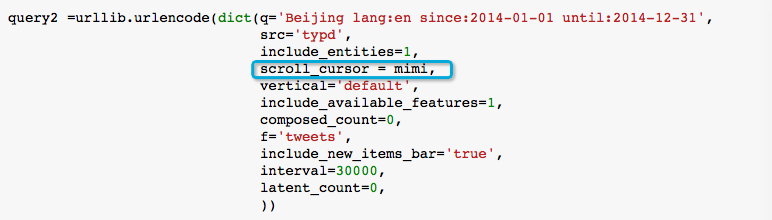

In [9]:
from IPython.display import Image
Image(filename='t3.png')

###服务器限制 (设定延迟)

因为推特服务器设置每小时不得超过720次的请求，因此我们要设定延迟，以防服务器拒绝返回数据。

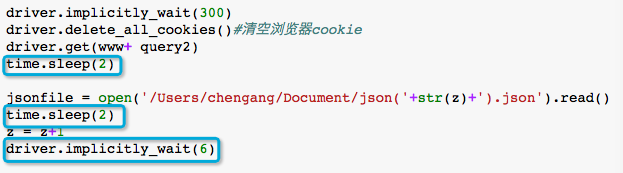

In [10]:
from IPython.display import Image
Image(filename='t4.png')

###时间规模 (设置代理之SSL认证-群集)

这样大概的效率是：每小时可以抓取 50M 的 json 文件，大概 18000 条 tweets 记录。那么我们获取一个有50万记录的关键字数据，就要大概两天的时间。

加速的办法就是用代理 IP, 分 100 个进程抓取 100 个关键字， 那么 2 天就可以完成任务了。然而在 selenium 中用代理的结果，是 SSL 无法通过验证，可能是因为代理的缘故，必要的认证信息在传输过程中漏掉了。无论是设置接收错误验证还是忽略验证，返回结果依然是：

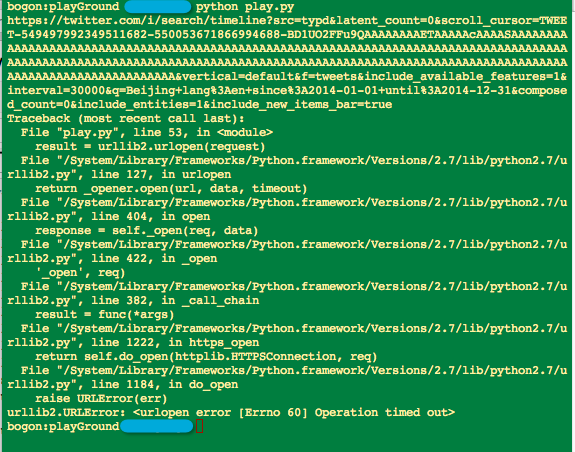

In [11]:
from IPython.display import Image
Image(filename='t2.png')

这样，最后的手段就是用集群计算机，分实际 IP 来进行操作，这样就可以提高效率，在一定的时间内获取以关键字为参数的 Twitter 数据集。

如果有更好地方法，或者成功使用代理的方式，欢迎邮件告知。

###单线程成功获取的 json 数据：

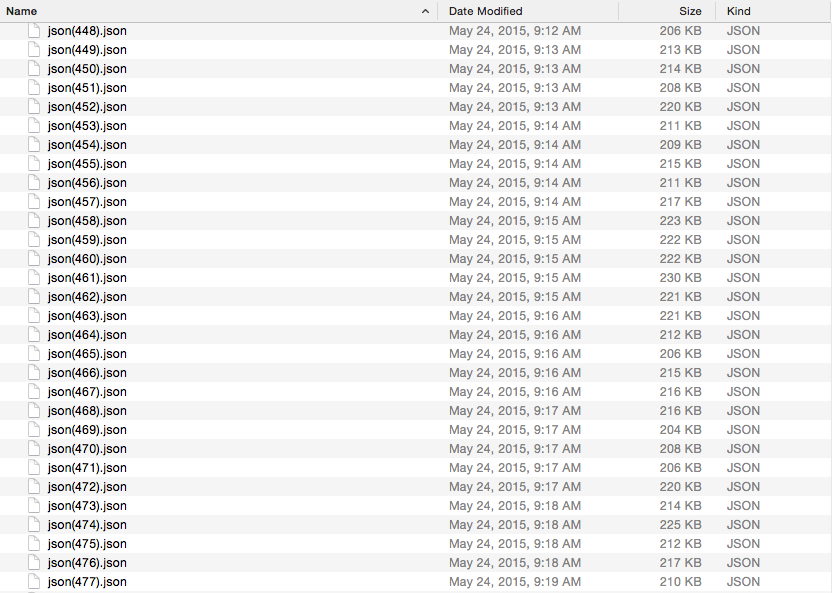

In [12]:
from IPython.display import Image
Image(filename='t5.png')